In [1]:
import scipy.io
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
from matplotlib import pyplot as plt


#Read in data of input/output
data = scipy.io.loadmat('HW4.mat')

X = data['X']
y = data['Y']

#Cross validation splits
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    train_size = 143, #amount of training data is 25% of all data so 569 * 0.25 = 143
                                                    random_state = 2) 



In [24]:
# ------------------------ Question 1 -------------------------------

# -----------------------------sklearn library adaboost implementation ----------------------


# --------------------- 1(a) with sklearn library (note: no tree node implementation due to using sklearn adaboost lib without CART) -----------------------

from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import mean_squared_error
import statistics as s

MSE_sk_list = []

for i in range(1, 300):
    clf = AdaBoostClassifier(n_estimators=i, random_state=0)
    clf.fit(X_train, y_train.flatten())

    y_pred = clf.predict(X_test)
    MSE_sk_list.append(mean_squared_error(y_test, y_pred))




Mean classification accuracy (MSE) of the approaches in (Sklearn) part 1(a)

Adaboosting:  0.1911222070438237


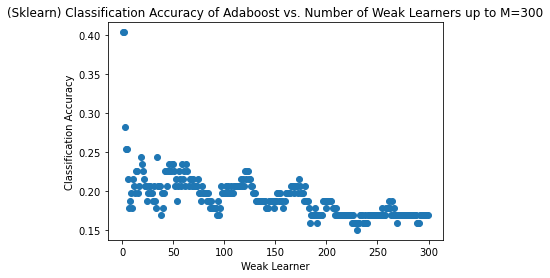

In [65]:
M_plt = list(range(1, 300))

MSE_mean =  s.mean(MSE_sk_list)

print("Mean classification accuracy (MSE) of the approaches in (Sklearn) part 1(a)")
print()
print("Adaboosting: ", MSE_mean)

plt.scatter(x = M_plt, y = MSE_sk_list)
    
plt.title("(Sklearn) Classification Accuracy of Adaboost vs. Number of Weak Learners up to M=300")
plt.xlabel("Weak Learner")
plt.ylabel("Classification Accuracy")

plt.show()

In [55]:
# -------------------- 1(b) with sklearn library ----------------------------

#implement shrinkage (Ridge)
from sklearn.linear_model import Ridge

f_shrink = Ridge(alpha=0.9)
f_shrink.fit(X_train, y_train.flatten())
X_train_shrink = f_shrink.predict(X_train)
X_train_shrink = np.reshape(X_train_shrink,(-1,1))

MSE_sk_list_shrunk = [] 

#Apply new shrinked training data to pre-written adaboost
for i in range(1, 300):
    clf = AdaBoostClassifier(n_estimators=i, random_state=0)
    clf.fit(X_train_shrink, y_train.flatten())

    y_pred = clf.predict(X_test.reshape(-1, 1))
    y_pred_filter = y_pred[0: 426]
    MSE_sk_list_shrunk.append(mean_squared_error(y_test, y_pred_filter))
    


Mean classification accuracy (MSE) of the approaches in (Sklearn) part 1(b)

Adaboosting with shrinkage on 5-node trees:  2.1294141661563586
Adaboosting without shrinkage on 5-node trees:  0.1911222070438237



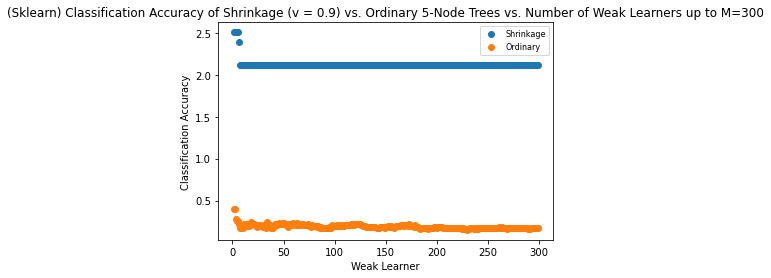

In [64]:
M_plt = list(range(1, 300))

#Classification accuracy
MSE_shrink = s.mean(MSE_sk_list_shrunk)
MSE_ord = s.mean(MSE_sk_list)

print("Mean classification accuracy (MSE) of the approaches in (Sklearn) part 1(b)")
print()
print("Adaboosting with shrinkage on 5-node trees: ", MSE_shrink)
print("Adaboosting without shrinkage on 5-node trees: ", MSE_ord)
print()
    
shrink_plt = plt.scatter(x = M_plt, y = MSE_sk_list_shrunk)
ord_plt = plt.scatter(x = M_plt, y = MSE_sk_list)


plt.title("(Sklearn) Classification Accuracy of Shrinkage (v = 0.9) vs. Ordinary 5-Node Trees vs. Number of Weak Learners up to M=300")
plt.xlabel("Weak Learner")
plt.ylabel("Classification Accuracy")

plt.legend((shrink_plt, ord_plt), ("Shrinkage", "Ordinary"), fontsize = 8)

plt.show()

In [66]:
# -----------------------------personal adaboost implementation ----------------------

#Implementation of adaboost

#Implement methods to calulate error rate, alpha, and update the weights

def error(y, y_pred, weight): #computing error of weak learner m
    return (sum(weight * (np.not_equal(y, y_pred)).astype(int)))/sum(weight)

def alpha(err): #calculate alpha which is weight of weak learner m
    return np.log((1 - err) / err)

def update(weight, alpha, y, y_pred): #update weights after adaboost iterations
    return weight * np.exp(alpha * (np.not_equal(y, y_pred)).astype(int))


#Create the adaboost class

class AdaBoost:
    
    def __init__(self):
        
        self.alphas = []
        self.weak_learners = []
        self.M = None
        self.nodes = None
        self.errors = []

    def fit(self, X, y, M = 100, nodes = 1):
        
        # Initialize params
        self.alphas = [] 
        self.errors = []
        self.M = M
        self.nodes = nodes

        # Iterate over M weak learners
        for m in range(0, M):
            
            # Set weights for current iteration
            if m == 0:
                weight = np.ones(len(y)) * 1 / len(y)  # At m = 0, weights are all the same and equal to 1 / N
            else:
                #Update weight
                weight = update(weight, m_alpha, y, y_pred)
            
            # Fit weak learner and predict labels
            w_learner = DecisionTreeClassifier(max_leaf_nodes = self.nodes)   # user set Number of nodes
            w_learner.fit(X, y, sample_weight = weight)
            y_pred = w_learner.predict(X)
            
            self.weak_learners.append(w_learner) # Save to list of weak learners

            # Compute error and alpha
            m_error = error(y, y_pred, weight)
            self.errors.append(m_error)

            m_alpha = alpha(m_error)
            self.alphas.append(m_alpha)

        assert len(self.weak_learners) == len(self.alphas)

    def predict(self, X): #predict on test set with fitted model

        # Initialise dataframe with weak learners for each observation
        weak_predictions = pd.DataFrame(index = range(len(X)), columns = range(self.M)) 

        # Predict class label for each weak learner, weighted by m_alpha
        for m in range(self.M):
            y_pred_m = self.weak_learners[m].predict(X) * self.alphas[m]
            weak_predictions.iloc[:,m] = y_pred_m

        # Calculate final predictions
        y_pred = (1 * np.sign(weak_predictions.T.sum())).astype(int)

        return y_pred

In [67]:
import statistics as s

# ------------ 1(a) personal -------------- 

#implement model onto data

#Stump model

# Fit model
stump = AdaBoost()
stump.fit(X_train, y_train.flatten(), M = 300, nodes = 2) #flatten y_train to 1d array
# predict
stump.predict(X_test)

#5-node tree model

#Fit model
f_node = AdaBoost()
f_node.fit(X_train, y_train.flatten(), M = 300, nodes = 3)
#predict
f_node.predict(X_test)

#10-node tree model

#Fit model
t_node = AdaBoost()
t_node.fit(X_train, y_train.flatten(), M = 300, nodes = 5)
#predict
t_node.predict(X_test)


#Classification error

MSE_stump = s.mean(stump.errors)
MSE_f_node = s.mean(f_node.errors)
MSE_t_node = s.mean(t_node.errors)

Mean classification accuracy (MSE) of the approaches in part 1(a)

Adaboosting with stumps:  0.22679668199356195
Adaboosting with 5-node trees:  0.09583357258648321
Adaboosting with 10-node trees:  0.009035993057869203



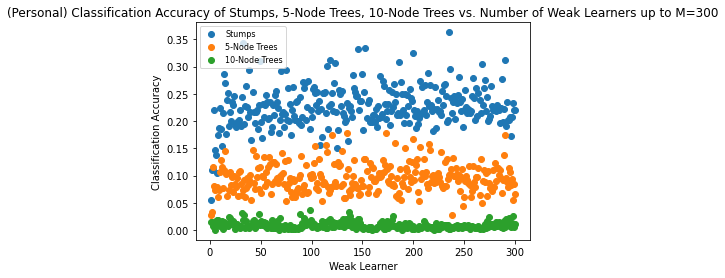

In [68]:
print("Mean classification accuracy (MSE) of the approaches in part 1(a)")
print()
print("Adaboosting with stumps: ", MSE_stump)
print("Adaboosting with 5-node trees: ", MSE_f_node)
print("Adaboosting with 10-node trees: ", MSE_t_node)
print()

#Plot of classification error

M_plt = list(range(1, 301))

stump_acc = stump.errors
f_acc = f_node.errors
t_acc = t_node.errors

stump_plt = plt.scatter(x = M_plt, y = stump_acc)
f_plt = plt.scatter(x = M_plt, y = f_acc)
t_plt = plt.scatter(x = M_plt, y = t_acc)

plt.title("(Personal) Classification Accuracy of Stumps, 5-Node Trees, 10-Node Trees vs. Number of Weak Learners up to M=300")
plt.xlabel("Weak Learner")
plt.ylabel("Classification Accuracy")

plt.legend((stump_plt, f_plt, t_plt), ("Stumps", "5-Node Trees", "10-Node Trees"), fontsize = 8)

plt.show()

Mean classification accuracy (MSE) of the approaches in part 1(b)

Adaboosting with shrinkage on 5-node trees:  0.2740065996545766
Adaboosting without shrinkage on 5-node trees:  0.09583357258648321



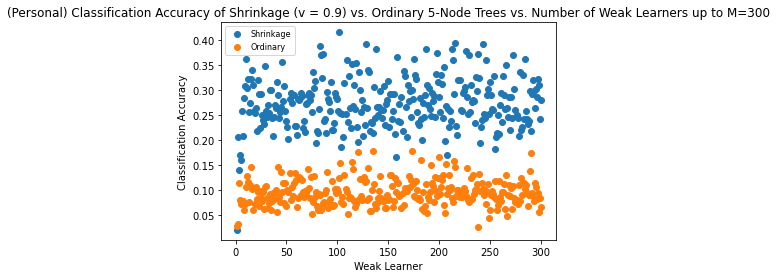

In [69]:
# --------------- 1(b) personal ------------------

#implement shrinkage (Ridge)
from sklearn.linear_model import Ridge

f_shrink = Ridge(alpha=0.9)
f_shrink.fit(X_train, y_train.flatten())
X_train_shrink = f_shrink.predict(X_train)
X_train_shrink = np.reshape(X_train_shrink,(-1,1))

#Apply new shrinked training data to pre-written adaboost
f_shrink_ad = AdaBoost()
f_shrink_ad.fit(X_train_shrink, y_train.flatten(), M = 300, nodes = 3)

#Get classification accuracy to compare shrunk and ordinary classifier
f_shrink_acc = f_shrink_ad.errors
f_ord_acc = f_node.errors

#Classification accuracy
MSE_shrink = s.mean(f_shrink_acc)
MSE_ord = s.mean(f_ord_acc)

print("Mean classification accuracy (MSE) of the approaches in part 1(b)")
print()
print("Adaboosting with shrinkage on 5-node trees: ", MSE_shrink)
print("Adaboosting without shrinkage on 5-node trees: ", MSE_ord)
print()

#Plot the results

M_plt = list(range(1, 301))

f_shrink_plt = plt.scatter(x = M_plt, y = f_shrink_acc)
f_ord_plt = plt.scatter(x = M_plt, y = f_ord_acc)


plt.title("(Personal) Classification Accuracy of Shrinkage (v = 0.9) vs. Ordinary 5-Node Trees vs. Number of Weak Learners up to M=300")
plt.xlabel("Weak Learner")
plt.ylabel("Classification Accuracy")

plt.legend((f_shrink_plt, f_ord_plt), ("Shrinkage", "Ordinary"), fontsize = 8)

plt.show()

In [3]:
# ------------------------------------------- Problem 2 -------------------------------------------


# -----------------------------sklearn library random forest implementation ----------------------

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

#Scale our features

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


#-------------- 2(a) sklearn library ----------------

#Train Aglorithm with sklearn Random Forest

from sklearn.ensemble import RandomForestRegressor

MSE_list = []
n_trees = list(range(1,301))

for trees in range(1, 301):
    #set max number of splits to n - 1 where n is size of training samples used
    rand_forest = RandomForestRegressor(n_estimators = trees, max_samples = len(X_train) - 1) #n_estimators: number of trees
    rand_forest.fit(X_train, y_train.flatten())
    y_pred = rand_forest.predict(X_test)
    MSE_list.append(mean_squared_error(y_test, y_pred))



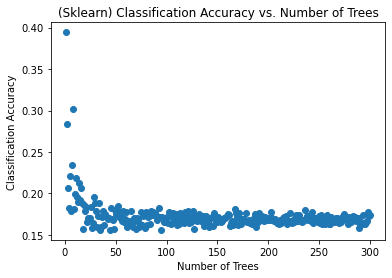

In [76]:
#Plot the results
 
plt.scatter(x = n_trees, y = MSE_list)

plt.title("(Sklearn) Classification Accuracy vs. Number of Trees")
plt.xlabel("Number of Trees")
plt.ylabel("Classification Accuracy")

plt.show()

In [78]:
#----------------- 2(b) sklearn library -------------------

#implementing depth control with min_samples_leaf between 1 - 10

MSE_list = []
MSE_list1 = []
MSE_list2 = []
MSE_list3 = []
MSE_list4 = []
MSE_list5 = []
MSE_list6 = []
MSE_list7 = []
MSE_list8 = []
MSE_list9 = []
MSE_list10 = []

#ordinary sample

for trees in range(1, 101):
    #set max number of splits to n - 1 where n is size of training samples used
    rand_forest = RandomForestRegressor(n_estimators = trees, max_samples = len(X_train) - 1) #n_estimators: number of trees
    rand_forest.fit(X_train, y_train.flatten())
    y_pred = rand_forest.predict(X_test)
    MSE_list.append(mean_squared_error(y_test, y_pred))
    
#1 sample per terminal node

for trees in range(1, 101): #just going to use 100 trees for the sake of runtime and graph visualization
    #set max number of splits to n - 1 where n is size of training samples used
    rand_forest = RandomForestRegressor(n_estimators = trees, max_samples = len(X_train) - 1, min_samples_leaf = 1) #n_estimators: number of trees
    rand_forest.fit(X_train, y_train.flatten())
    y_pred = rand_forest.predict(X_test)
    MSE_list1.append(mean_squared_error(y_test, y_pred))
    
#2 samples per terminal node
    
for trees in range(1, 101): #just going to use 100 trees for the sake of runtime
    #set max number of splits to n - 1 where n is size of training samples used
    rand_forest = RandomForestRegressor(n_estimators = trees, max_samples = len(X_train) - 1, min_samples_leaf = 2) 
    rand_forest.fit(X_train, y_train.flatten())
    y_pred = rand_forest.predict(X_test)
    MSE_list2.append(mean_squared_error(y_test, y_pred))

#3 samples per terminal node
    
for trees in range(1, 101): #just going to use 100 trees for the sake of runtime
    #set max number of splits to n - 1 where n is size of training samples used
    rand_forest = RandomForestRegressor(n_estimators = trees, max_samples = len(X_train) - 1, min_samples_leaf = 3) 
    rand_forest.fit(X_train, y_train.flatten())
    y_pred = rand_forest.predict(X_test)
    MSE_list3.append(mean_squared_error(y_test, y_pred))
    
#4 samples per terminal node
    
for trees in range(1, 101): #just going to use 100 trees for the sake of runtime
    #set max number of splits to n - 1 where n is size of training samples used
    rand_forest = RandomForestRegressor(n_estimators = trees, max_samples = len(X_train) - 1, min_samples_leaf = 4) #n_estimators: number of trees
    rand_forest.fit(X_train, y_train.flatten())
    y_pred = rand_forest.predict(X_test)
    MSE_list4.append(mean_squared_error(y_test, y_pred))

#5 samples per terminal node
    
for trees in range(1, 101): #just going to use 100 trees for the sake of runtime
    #set max number of splits to n - 1 where n is size of training samples used
    rand_forest = RandomForestRegressor(n_estimators = trees, max_samples = len(X_train) - 1, min_samples_leaf = 5) #n_estimators: number of trees
    rand_forest.fit(X_train, y_train.flatten())
    y_pred = rand_forest.predict(X_test)
    MSE_list5.append(mean_squared_error(y_test, y_pred))
    
#6 samples per terminal node
    
for trees in range(1, 101): #just going to use 100 trees for the sake of runtime
    #set max number of splits to n - 1 where n is size of training samples used
    rand_forest = RandomForestRegressor(n_estimators = trees, max_samples = len(X_train) - 1, min_samples_leaf = 6) #n_estimators: number of trees
    rand_forest.fit(X_train, y_train.flatten())
    y_pred = rand_forest.predict(X_test)
    MSE_list6.append(mean_squared_error(y_test, y_pred))
    
#7 samples per terminal node
    
for trees in range(1, 101): #just going to use 100 trees for the sake of runtime
    #set max number of splits to n - 1 where n is size of training samples used
    rand_forest = RandomForestRegressor(n_estimators = trees, max_samples = len(X_train) - 1, min_samples_leaf = 7) #n_estimators: number of trees
    rand_forest.fit(X_train, y_train.flatten())
    y_pred = rand_forest.predict(X_test)
    MSE_list7.append(mean_squared_error(y_test, y_pred))
    
#8 samples per terminal node
    
for trees in range(1, 101): #just going to use 100 trees for the sake of runtime
    #set max number of splits to n - 1 where n is size of training samples used
    rand_forest = RandomForestRegressor(n_estimators = trees, max_samples = len(X_train) - 1, min_samples_leaf = 8) #n_estimators: number of trees
    rand_forest.fit(X_train, y_train.flatten())
    y_pred = rand_forest.predict(X_test)
    MSE_list8.append(mean_squared_error(y_test, y_pred))
    
#9 samples per terminal node
    
for trees in range(1, 101): #just going to use 100 trees for the sake of runtime
    #set max number of splits to n - 1 where n is size of training samples used
    rand_forest = RandomForestRegressor(n_estimators = trees, max_samples = len(X_train) - 1, min_samples_leaf = 9) #n_estimators: number of trees
    rand_forest.fit(X_train, y_train.flatten())
    y_pred = rand_forest.predict(X_test)
    MSE_list9.append(mean_squared_error(y_test, y_pred))
    
#10 samples per terminal node
    
for trees in range(1, 101): #just going to use 100 trees for the sake of runtime
    #set max number of splits to n - 1 where n is size of training samples used
    rand_forest = RandomForestRegressor(n_estimators = trees, max_samples = len(X_train) - 1, min_samples_leaf = 10) #n_estimators: number of trees
    rand_forest.fit(X_train, y_train.flatten())
    y_pred = rand_forest.predict(X_test)
    MSE_list10.append(mean_squared_error(y_test, y_pred))
    

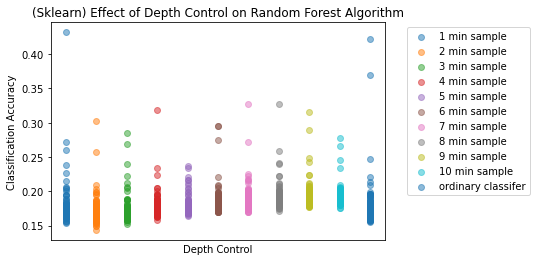

In [79]:
#Plotting

x_plt1 = [1] * 100
x_plt2 = [2] * 100
x_plt3 = [3] * 100
x_plt4 = [4] * 100
x_plt5 = [5] * 100
x_plt6 = [6] * 100
x_plt7 = [7] * 100
x_plt8 = [8] * 100
x_plt9 = [9] * 100
x_plt10 = [10] * 100

x_ord = [11] * 100

#plots with depth control

plt1 = plt.scatter(x_plt1, MSE_list1, alpha = 0.5)
plt2 = plt.scatter(x_plt2, MSE_list2, alpha = 0.5)
plt3 = plt.scatter(x_plt3, MSE_list3, alpha = 0.5)
plt4 = plt.scatter(x_plt4, MSE_list4, alpha = 0.5)
plt5 = plt.scatter(x_plt5, MSE_list5, alpha = 0.5)
plt6 = plt.scatter(x_plt6, MSE_list6, alpha = 0.5)
plt7 = plt.scatter(x_plt7, MSE_list7, alpha = 0.5)
plt8 = plt.scatter(x_plt8, MSE_list8, alpha = 0.5)
plt9 = plt.scatter(x_plt9, MSE_list9, alpha = 0.5)
plt10 = plt.scatter(x_plt10, MSE_list10, alpha = 0.5)


#ordinary plot without depth control
plt_ord = plt.scatter(x_ord, MSE_list, alpha = 0.5)

plt.title("(Sklearn) Effect of Depth Control on Random Forest Algorithm")
plt.xlabel("Depth Control")
plt.ylabel("Classification Accuracy")

plt.legend((plt1, plt2, plt3, plt4, plt5, plt6, plt7, plt8, plt9, plt10, plt_ord), 
           ("1 min sample", "2 min sample", "3 min sample", "4 min sample", "5 min sample", "6 min sample", "7 min sample", "8 min sample", "9 min sample", "10 min sample", "ordinary classifer"),
          fontsize = 10, bbox_to_anchor=(1.05, 1.0), loc='upper left')


ax = plt.gca()
ax.axes.xaxis.set_ticks([])



plt.show()




In [17]:
#---------------------------- personal implementation of random forest -----------------------------

from collections import Counter
from sklearn.tree import DecisionTreeClassifier #get decision tree


def bootstrap_sample(X, y):
    n_samples = X.shape[0]
    idxs = np.random.choice(n_samples, n_samples, replace=True)
    return X[idxs], y[idxs]


def most_common_label(y):
    counter = Counter(y)
    most_common = counter.most_common(1)[0][0]
    return most_common

class RandomForest:
    def __init__(self, n_trees=10, min_samples_split=2, max_depth=100, max_features = None, min_samples_leaf = 1):
        self.n_trees = n_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.max_features = max_features
        self.min_samples_leaf = min_samples_leaf
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTreeClassifier(
                min_samples_split=self.min_samples_split,
                max_depth=self.max_depth,
                max_features=self.max_features,
                min_samples_leaf = self.min_samples_leaf
            )
            X_samp, y_samp = bootstrap_sample(X, y)
            tree.fit(X_samp, y_samp)
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(tree_preds, 0, 1)
        y_pred = [most_common_label(tree_pred) for tree_pred in tree_preds]
        return np.array(y_pred)

In [19]:
#-------------- 2(a) personal  ----------------

from sklearn.metrics import mean_squared_error

MSE_list = []
n_trees = list(range(1,301))

for trees in range(1, 301):
    rand_forest = RandomForest(n_trees = trees, min_samples_split = len(X_train) - 1) #max_samples_split = maximum number of splits
    rand_forest.fit(X_train, y_train.flatten())
    y_pred = rand_forest.predict(X_test)
    MSE_list.append(mean_squared_error(y_test, y_pred))


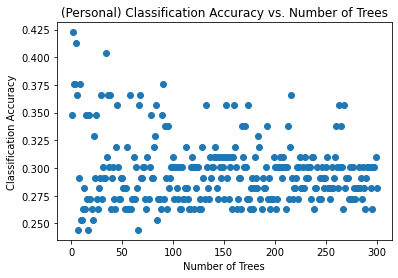

In [20]:
#Plot the results
 
plt.scatter(x = n_trees, y = MSE_list)

plt.title("(Personal) Classification Accuracy vs. Number of Trees")
plt.xlabel("Number of Trees")
plt.ylabel("Classification Accuracy")

plt.show()

In [22]:
#----------------- 2(b) personal library -------------------

#implementing depth control with min_samples_leaf between 1 - 10

MSE_list = []
MSE_list1 = []
MSE_list2 = []
MSE_list3 = []
MSE_list4 = []
MSE_list5 = []
MSE_list6 = []
MSE_list7 = []
MSE_list8 = []
MSE_list9 = []
MSE_list10 = []

#ordinary sample

for trees in range(1, 101):
    #set max number of splits to n - 1 where n is size of training samples used
    rand_forest = RandomForest(n_trees = trees, min_samples_split = len(X_train) - 1) #max_samples_split = maximum number of splits
    rand_forest.fit(X_train, y_train.flatten())
    y_pred = rand_forest.predict(X_test)
    MSE_list.append(mean_squared_error(y_test, y_pred))
    
#1 sample per terminal node

for trees in range(1, 101): #just going to use 100 trees for the sake of runtime and graph visualization
    #set max number of splits to n - 1 where n is size of training samples used
    rand_forest = RandomForest(n_trees = trees, min_samples_split = len(X_train) - 1, min_samples_leaf = 1) #min_samples_leaf: min number of samples per terminal node
    rand_forest.fit(X_train, y_train.flatten())
    y_pred = rand_forest.predict(X_test)
    MSE_list1.append(mean_squared_error(y_test, y_pred))
    
#2 samples per terminal node
    
for trees in range(1, 101): #just going to use 100 trees for the sake of runtime
    #set max number of splits to n - 1 where n is size of training samples used
    rand_forest = RandomForest(n_trees = trees, min_samples_split = len(X_train) - 1, min_samples_leaf = 2) #min_samples_leaf: min number of samples per terminal node
    rand_forest.fit(X_train, y_train.flatten())
    y_pred = rand_forest.predict(X_test)
    MSE_list2.append(mean_squared_error(y_test, y_pred))

#3 samples per terminal node
    
for trees in range(1, 101): #just going to use 100 trees for the sake of runtime
    #set max number of splits to n - 1 where n is size of training samples used
    rand_forest = RandomForest(n_trees = trees, min_samples_split = len(X_train) - 1, min_samples_leaf = 3) #min_samples_leaf: min number of samples per terminal node
    rand_forest.fit(X_train, y_train.flatten())
    y_pred = rand_forest.predict(X_test)
    MSE_list3.append(mean_squared_error(y_test, y_pred))
    
#4 samples per terminal node
    
for trees in range(1, 101): #just going to use 100 trees for the sake of runtime
    #set max number of splits to n - 1 where n is size of training samples used
    rand_forest = RandomForest(n_trees = trees, min_samples_split = len(X_train) - 1, min_samples_leaf = 4) #min_samples_leaf: min number of samples per terminal node
    rand_forest.fit(X_train, y_train.flatten())
    y_pred = rand_forest.predict(X_test)
    MSE_list4.append(mean_squared_error(y_test, y_pred))

#5 samples per terminal node
    
for trees in range(1, 101): #just going to use 100 trees for the sake of runtime
    #set max number of splits to n - 1 where n is size of training samples used
    rand_forest = RandomForest(n_trees = trees, min_samples_split = len(X_train) - 1, min_samples_leaf = 5) #min_samples_leaf: min number of samples per terminal node
    rand_forest.fit(X_train, y_train.flatten())
    y_pred = rand_forest.predict(X_test)
    MSE_list5.append(mean_squared_error(y_test, y_pred))
    
#6 samples per terminal node
    
for trees in range(1, 101): #just going to use 100 trees for the sake of runtime
    #set max number of splits to n - 1 where n is size of training samples used
    rand_forest = RandomForest(n_trees = trees, min_samples_split = len(X_train) - 1, min_samples_leaf = 6) #min_samples_leaf: min number of samples per terminal node
    rand_forest.fit(X_train, y_train.flatten())
    y_pred = rand_forest.predict(X_test)
    MSE_list6.append(mean_squared_error(y_test, y_pred))
    
#7 samples per terminal node
    
for trees in range(1, 101): #just going to use 100 trees for the sake of runtime
    #set max number of splits to n - 1 where n is size of training samples used
    rand_forest = RandomForest(n_trees = trees, min_samples_split = len(X_train) - 1, min_samples_leaf = 7) #min_samples_leaf: min number of samples per terminal node
    rand_forest.fit(X_train, y_train.flatten())
    y_pred = rand_forest.predict(X_test)
    MSE_list7.append(mean_squared_error(y_test, y_pred))
    
#8 samples per terminal node
    
for trees in range(1, 101): #just going to use 100 trees for the sake of runtime
    #set max number of splits to n - 1 where n is size of training samples used
    rand_forest = RandomForest(n_trees = trees, min_samples_split = len(X_train) - 1, min_samples_leaf = 8) #min_samples_leaf: min number of samples per terminal node
    rand_forest.fit(X_train, y_train.flatten())
    y_pred = rand_forest.predict(X_test)
    MSE_list8.append(mean_squared_error(y_test, y_pred))
    
#9 samples per terminal node
    
for trees in range(1, 101): #just going to use 100 trees for the sake of runtime
    #set max number of splits to n - 1 where n is size of training samples used
    rand_forest = RandomForest(n_trees = trees, min_samples_split = len(X_train) - 1, min_samples_leaf = 9) #min_samples_leaf: min number of samples per terminal node
    rand_forest.fit(X_train, y_train.flatten())
    y_pred = rand_forest.predict(X_test)
    MSE_list9.append(mean_squared_error(y_test, y_pred))
    
#10 samples per terminal node
    
for trees in range(1, 101): #just going to use 100 trees for the sake of runtime
    #set max number of splits to n - 1 where n is size of training samples used
    rand_forest = RandomForest(n_trees = trees, min_samples_split = len(X_train) - 1, min_samples_leaf = 10) #min_samples_leaf: min number of samples per terminal node
    rand_forest.fit(X_train, y_train.flatten())
    y_pred = rand_forest.predict(X_test)
    MSE_list10.append(mean_squared_error(y_test, y_pred))
    

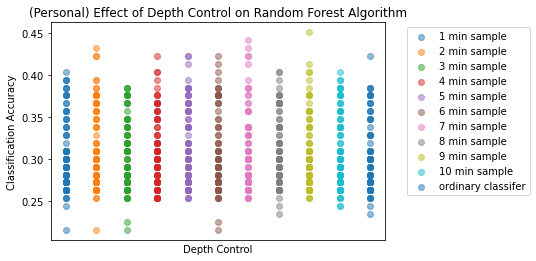

In [24]:
#Plotting

x_plt1 = [1] * 100
x_plt2 = [2] * 100
x_plt3 = [3] * 100
x_plt4 = [4] * 100
x_plt5 = [5] * 100
x_plt6 = [6] * 100
x_plt7 = [7] * 100
x_plt8 = [8] * 100
x_plt9 = [9] * 100
x_plt10 = [10] * 100

x_ord = [11] * 100

#plots with depth control

plt1 = plt.scatter(x_plt1, MSE_list1, alpha = 0.5)
plt2 = plt.scatter(x_plt2, MSE_list2, alpha = 0.5)
plt3 = plt.scatter(x_plt3, MSE_list3, alpha = 0.5)
plt4 = plt.scatter(x_plt4, MSE_list4, alpha = 0.5)
plt5 = plt.scatter(x_plt5, MSE_list5, alpha = 0.5)
plt6 = plt.scatter(x_plt6, MSE_list6, alpha = 0.5)
plt7 = plt.scatter(x_plt7, MSE_list7, alpha = 0.5)
plt8 = plt.scatter(x_plt8, MSE_list8, alpha = 0.5)
plt9 = plt.scatter(x_plt9, MSE_list9, alpha = 0.5)
plt10 = plt.scatter(x_plt10, MSE_list10, alpha = 0.5)


#ordinary plot without depth control
plt_ord = plt.scatter(x_ord, MSE_list, alpha = 0.5)

plt.title("(Personal) Effect of Depth Control on Random Forest Algorithm")
plt.xlabel("Depth Control")
plt.ylabel("Classification Accuracy")

plt.legend((plt1, plt2, plt3, plt4, plt5, plt6, plt7, plt8, plt9, plt10, plt_ord), 
           ("1 min sample", "2 min sample", "3 min sample", "4 min sample", "5 min sample", "6 min sample", "7 min sample", "8 min sample", "9 min sample", "10 min sample", "ordinary classifer"),
          fontsize = 10, bbox_to_anchor=(1.05, 1.0), loc='upper left')


ax = plt.gca()
ax.axes.xaxis.set_ticks([])



plt.show()


